In [13]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# 1. 不使用数据增强的快速特征提取

In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '../../data/Dogs vs. Cats/my-train'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# 特征提取
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    # batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
63/63 [==============================] - 1s 8ms/step - loss: 0.6106 - acc: 0.6610 - val_loss: 0.4764 - val_acc: 0.8260
Epoch 2/30
63/63 [==============================] - 0s 6ms/step - loss: 0.4483 - acc: 0.8040 - val_loss: 0.4029 - val_acc: 0.8390
Epoch 3/30
63/63 [==============================] - 0s 6ms/step - loss: 0.4023 - acc: 0.8145 - val_loss: 0.3573 - val_acc: 0.8570
Epoch 4/30
63/63 [==============================] - 0s 7ms/step - loss: 0.3551 - acc: 0.8445 - val_loss: 0.3248 - val_acc: 0.8820
Epoch 5/30
63/63 [==============================] - 0s 7ms/step - loss: 0.3189 - acc: 0.8655 - val_loss: 0.3058 - val_acc: 0.8890
Epoch 6/30
63/63 [==============================] - 0s 6ms/step - loss: 0.2844 - acc: 0.8910 - val_loss: 0.3025 - val_acc: 0.8780
Epoch 7/30
63/63 [==============================] - 0s 6ms/step - loss: 0.2769 - acc: 0.8840 - val_loss: 0.2867 - val_acc: 0.8930
Epoch 8/30
63/63 [==============================] - 0s 6ms/step - loss: 0.2578 - acc: 0.90

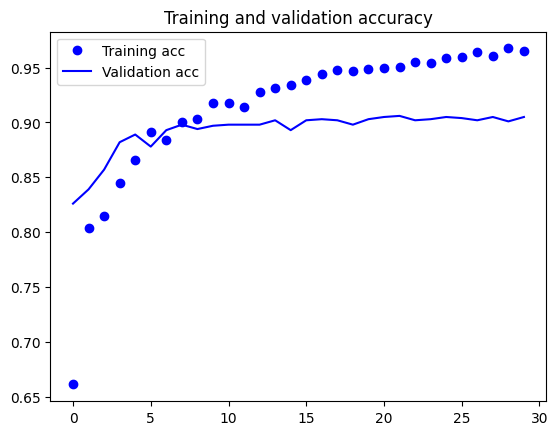

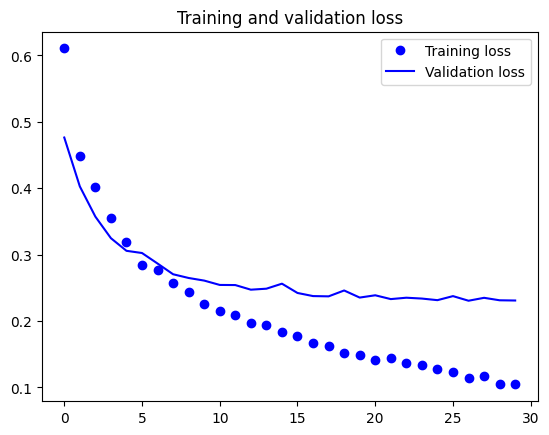

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 2. 使用数据增强的特征提取

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
print('This is the number of trainable weights '
    'before freezing the conv base:', len(model.trainable_weights))
# “冻结”卷积基
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# 不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # 目标目录
    train_dir,
    # 将所有图像的大小调整为 150×150
    target_size=(150, 150),
    batch_size=20,
    # 因为使用了binary_crossentropy损失，所以需要用二进制标签
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/30
100/100 - 18s - loss: 0.5759 - acc: 0.7090 - val_loss: 0.4266 - val_acc: 0.8410 - 18s/epoch - 177ms/step
Epoch 2/30
100/100 - 15s - loss: 0.4794 - acc: 0.7825 - val_loss: 0.3556 - val_acc: 0.8650 - 15s/epoch - 147ms/step
Epoch 3/30
100/100 - 15s - loss: 0.4225 - acc: 0.8180 - val_loss: 0.3256 - val_acc: 0.8750 - 15s/epoch - 146ms/step
Epoch 4/30
100/100 - 15s - loss: 0.4023 - acc: 0.8170 - val_loss: 0.3051 - val_acc: 0.8720 - 15s/epoch - 146ms/step
Epoch 5/30
100/100 - 15s - loss: 0.3840 - acc: 0.8335 - val_loss: 0.2848 - val_acc: 0.8870 - 15s/epoch - 146ms/step
Epoch 6/30
100/100 - 15s - loss: 0.3664 - acc: 0.8400 - val_loss: 0.2750 - val_acc: 0.8910 - 15s/epoch - 147ms/step
Epoch 7/30
100/100 - 15s - loss: 0.3560 - acc: 0.8445 - val_loss: 0.2683 - val_acc: 0.8960 - 15s/epoch - 147ms/step
Epoch 8/30
100/100 - 15s - loss: 0.3392 - acc: 0.8515 - val_loss: 0.2844 - val_acc: 0.8810 - 15s/epoch - 147ms/step
Epoch 9/30
100/100 - 15s - loss: 0.3450 - acc: 0.8520 - val_loss: 0.2572

In [23]:
model.save('cats_and_dogs_small_3.h5')

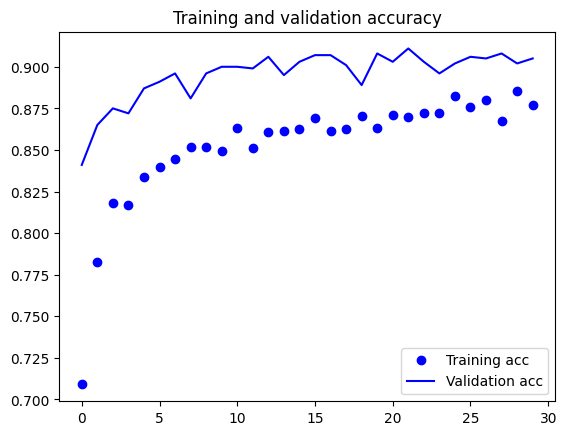

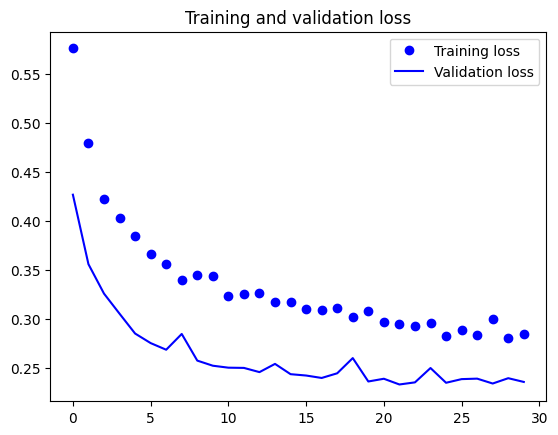

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 3.微调模型

In [25]:
conv_base.trainable = True
# 冻结直到某一层的所有层
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 175ms/step - loss: 0.3070 - acc: 0.8675 - val_loss: 0.2441 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 18s 175ms/step - loss: 0.2539 - acc: 0.8870 - val_loss: 0.1998 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2490 - acc: 0.8960 - val_loss: 0.2075 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2186 - acc: 0.9125 - val_loss: 0.1938 - val_acc: 0.9280
Epoch 5/100
100/100 [==============================] - 18s 178ms/step - loss: 0.2162 - acc: 0.9080 - val_loss: 0.2013 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 18s 175ms/step - loss: 0.1824 - acc: 0.9275 - val_loss: 0.1872 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 18s 175ms/step - loss: 0.1728 - acc: 0.9290 - val_loss: 0.1872 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

In [28]:
model.save('cats_and_dogs_small_4.h5')

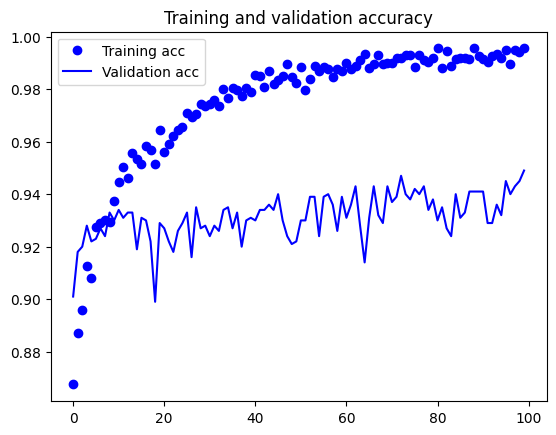

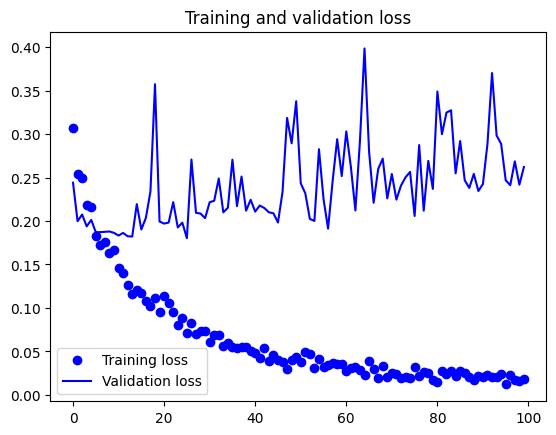

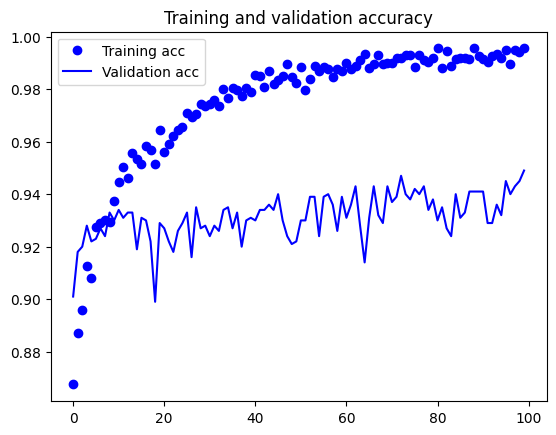

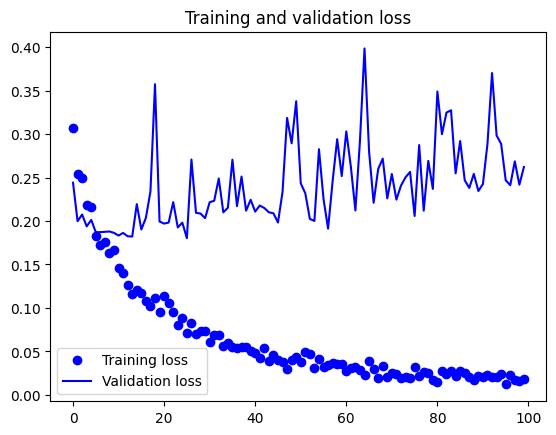

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

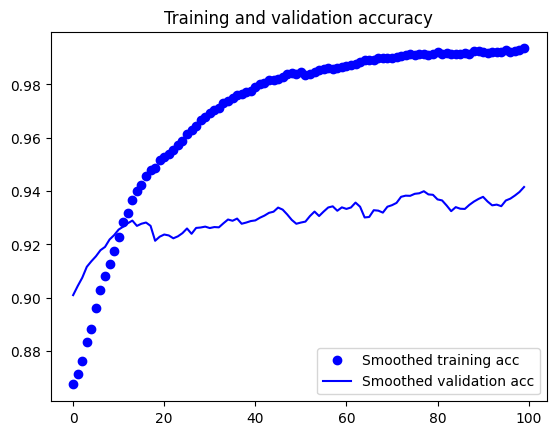

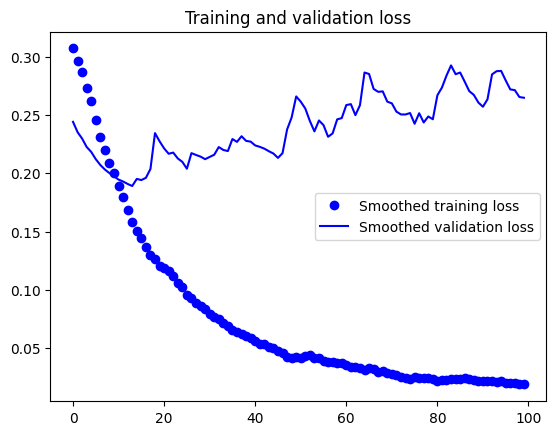

In [30]:
# 使曲线变得平滑
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 5s 98ms/step - loss: 0.3504 - acc: 0.9360
test acc: 0.9359999895095825
